In [7]:
from dimod import Binary, BQM, ExactSolver
import matplotlib.pyplot as plt
import dimod, re
import neal
import numpy as np
import seaborn as sns
import pandas as pd
import re

# Utils

In [8]:
P1_VAR_PREFIX = "P1_"
P2_VAR_PREFIX = "P2_"

from matplotlib.colors import ListedColormap

def plot_cost_matrix(costs, actions, other_actions):
    df = pd.DataFrame(costs, index=actions, columns=other_actions)
    sns.heatmap(df, cmap=ListedColormap(['white']), annot=True, annot_kws={"fontsize":16},
               cbar=False)
    plt.ylabel("Player 1", fontsize=18)
    plt.xlabel("Player 2", fontsize=18)
    plt.title("Player cost matrix", fontsize=20)

def plot_joint_cost_matrix(costs_p1, costs_p2, p1_actions, p2_actions):
    string_cost = []
    for i in range(len(p1_actions)):
        row = []
        for j in range(len(p2_actions)):
            row.append(f"({costs_p1[i][j]}, {costs_p2[i][j]})")
        string_cost.append(row)
    df = pd.DataFrame(np.zeros((len(p1_actions), len(p2_actions))), index=p1_actions, columns=p2_actions)
    sns.heatmap(df, cmap=ListedColormap(['white']), annot=np.asarray(string_cost), 
                annot_kws={"fontsize":16},
               cbar=False, fmt="")
    plt.ylabel("Player 1", fontsize=18)
    plt.xlabel("Player 2", fontsize=18)
    plt.title("Players joint cost matrix", fontsize=20)

In [9]:
def get_player_cost_matrix(player_costs, player_actions, other_actions):
    costs = np.zeros((len(player_actions), len(other_actions)))
    for action, p2_actions in player_costs.items():
        for other_action in p2_actions.keys():
            costs[player_actions.index(action)][other_actions.index(other_action)] = p2_actions[other_action]
    return costs

def get_cost_matrices(p1_costs, p2_costs, labels_p1, labels_p2):
    """
    Returns both cost matrix with player one in row space and player two in column space
    """
    costs_p1 = get_player_cost_matrix(p1_costs, labels_p1, labels_p2)
    costs_p2 = get_player_cost_matrix(p2_costs, labels_p2, labels_p1).T
    return costs_p1, costs_p2

In [451]:
def cost_matrices_to_bmq(p1_costs, p2_costs, labels_p1, labels_p2, lagrange_multiplier_scale=1):
    shape = p1_costs.shape
    sum_costs = p1_costs + p2_costs
    Q = {}
    for index1, action_p1 in enumerate(labels_p1):
        for index2, action_p2 in enumerate(labels_p2):
            Q[(P1_VAR_PREFIX+action_p1, P2_VAR_PREFIX+action_p2)] = -sum_costs[index1,index2]
    alpha_coefficients = [('alpha_0', -2**0), ('alpha_1', -2**1), ('alpha_2', -2**2), ('alpha_3', -2**3)]
    beta_coefficients = [('beta_0', -2**0), ('beta_1', -2**1), ('beta_2', -2**2), ('beta_3', -2**3)]
    for var, coef in alpha_coefficients+beta_coefficients:
        Q[(var,var)] = -coef
    print(Q)
    bqm = BQM(Q, vartype='BINARY')
    bqm.add_linear_equality_constraint([(P1_VAR_PREFIX+a, 1) for a in labels_p1], 
                                       constant=-1, lagrange_multiplier=lagrange_multiplier_scale*10)
    bqm.add_linear_equality_constraint([(P2_VAR_PREFIX+a, 1) for a in labels_p2],
                                       constant=-1, lagrange_multiplier=lagrange_multiplier_scale*10)
    for i, row in enumerate(p1_costs):
        bqm.add_linear_inequality_constraint(
            [(P2_VAR_PREFIX+action, num) for num, action in zip(row, labels_p2)]+alpha_coefficients, 
            lb=min(row), ub=max(row), lagrange_multiplier=lagrange_multiplier_scale, 
            label = f"P2_{i}_constr"
        )
    for i, row in enumerate(p2_costs):
        bqm.add_linear_inequality_constraint(
            [(P1_VAR_PREFIX+action, num) for num, action in zip(row, labels_p1)]+beta_coefficients, 
            lb=min(row), ub=max(row), lagrange_multiplier=lagrange_multiplier_scale, 
            label = f"P1_{i}_constr"
        )
    return bqm

In [421]:
def sampleset_result_plot(sampleset, labels_p1, labels_p2):
    sampleset = dimod.keep_variables(sampleset, 
                                     [P1_VAR_PREFIX+a for a in label_actions_p1]+
                                     [P2_VAR_PREFIX+a for a in label_actions_p2])
    sampleset = sampleset.aggregate()
    df = sampleset.to_pandas_dataframe().sort_values('num_occurrences',ascending=False)
    for c in [P1_VAR_PREFIX+a for a in label_actions_p1]+[P2_VAR_PREFIX+a for a in label_actions_p2]:
        df[c] = df[c].map(lambda x: c.split("_")[1] if x==1 else "")
    df["P1"] = df[[P1_VAR_PREFIX+a for a in label_actions_p1]].agg(''.join, axis=1)
    df["P2"] = df[[P2_VAR_PREFIX+a for a in label_actions_p2]].agg(''.join, axis=1)
    df["Strategy"] = "(" + df["P1"] + ", " + df["P2"] + ")"
    df.rename(columns={"num_occurrences": "Frequency"}, inplace=True)
    df = df[["Strategy", "Frequency"]]
    top_df = pd.concat([df.iloc[:5], 
                       pd.DataFrame({"Strategy": ["Others..."], "Frequency": [df.iloc[5:]["Frequency"].sum()]})], 
                       axis=0, ignore_index=True)
    sns.barplot(data=top_df, x="Strategy", y="Frequency", color=(0.4, 0.18, 0.62))
    plt.title("Frequency of each result", fontsize=20)
    plt.xticks(rotation=75, fontsize=14)
    plt.yticks(rotation=45, fontsize=14)
    plt.ylabel("Frequency", fontsize=18)
    plt.xlabel("Strategy", fontsize=18)

# Example: Battle of the sexes

In [332]:
ACTION_LABEL = "Action"
ROMANCE_LABEL = "Romance"

label_actions_p1 = [ACTION_LABEL, ROMANCE_LABEL]
label_actions_p2 = label_actions_p1
# Player 1 is male
p1_costs = {ACTION_LABEL: {ROMANCE_LABEL: -1, ACTION_LABEL: 2},
           ROMANCE_LABEL: {ACTION_LABEL: -1, ROMANCE_LABEL: 1}}
p2_costs = {ACTION_LABEL: {ROMANCE_LABEL: -1, ACTION_LABEL: 1},
           ROMANCE_LABEL: {ACTION_LABEL: -1, ROMANCE_LABEL: 2}}

In [333]:
costs_p1, costs_p2 = get_cost_matrices(p1_costs, p2_costs, label_actions_p1, label_actions_p2)

In [334]:
costs_p1

array([[ 2., -1.],
       [-1.,  1.]])

In [335]:
costs_p2

array([[ 1., -1.],
       [-1.,  2.]])

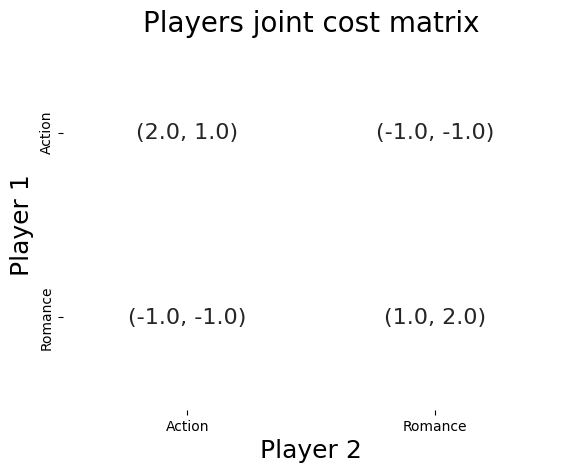

In [336]:
plot_joint_cost_matrix(costs_p1, costs_p2, label_actions_p1, label_actions_p2)

In [337]:
bqm = cost_matrices_to_bmq(costs_p1, costs_p2, label_actions_p1, label_actions_p2)

{('P1_Action', 'P2_Action'): -3.0, ('P1_Action', 'P2_Romance'): 2.0, ('P1_Romance', 'P2_Action'): 2.0, ('P1_Romance', 'P2_Romance'): -3.0, ('alpha_0', 'alpha_0'): 0.1, ('alpha_1', 'alpha_1'): 0.2, ('alpha_2', 'alpha_2'): 0.3, ('alpha_3', 'alpha_3'): 0.5, ('beta_0', 'beta_0'): 0.1, ('beta_1', 'beta_1'): 0.2, ('beta_2', 'beta_2'): 0.3, ('beta_3', 'beta_3'): 0.5}


/Users/gcafferata/.pyenv/versions/3.9.8/envs/qhackathon/lib/python3.9/site-packages/dimod/binary/binary_quadratic_model.py:759: UserWarning: For constraints with fractional coefficients, multiply both sides of the inequality by an appropriate factor of ten to attain or approximate integer coefficients. 
  warnings.warn("For constraints with fractional coefficients, "


In [338]:
sampler = neal.SimulatedAnnealingSampler()
sampleset = sampler.sample(bqm, num_reads=5000)
sampleset = dimod.keep_variables(sampleset, 
                                 [P1_VAR_PREFIX+a for a in label_actions_p1]+
                                 [P2_VAR_PREFIX+a for a in label_actions_p2])
sampleset = sampleset.aggregate()
sampleset.to_pandas_dataframe()

,P1_Action,P1_Romance,P2_Action,P2_Romance,energy,num_occurrences
0,0,1,0,1,-3.0,2444
1,1,0,1,0,-3.0,2412
2,1,0,0,1,2.0,94
3,0,1,1,0,2.0,50


# Policy makers template

In [492]:
AGRESSIVE_LABEL = "Agressive"
PASIVE_LABEL = "Passive"
MODERATE_LABEL = "Moderate"

label_actions_p1 = [AGRESSIVE_LABEL, PASIVE_LABEL, MODERATE_LABEL]
label_actions_p2 = [AGRESSIVE_LABEL, PASIVE_LABEL, MODERATE_LABEL]
p1_costs = {AGRESSIVE_LABEL: {AGRESSIVE_LABEL: -5/2, PASIVE_LABEL: 10/2, MODERATE_LABEL: 2.5/2},
           PASIVE_LABEL: {AGRESSIVE_LABEL: 0, PASIVE_LABEL: 2/2, MODERATE_LABEL: 1/2},
           MODERATE_LABEL: {AGRESSIVE_LABEL: -2.5/2, PASIVE_LABEL: 6/2, MODERATE_LABEL: 5/2}}
p2_costs = p1_costs

In [493]:
costs_p1, costs_p2 = get_cost_matrices(p1_costs, p2_costs, label_actions_p1, label_actions_p2)

In [494]:
costs_p1

array([[-2.5 ,  5.  ,  1.25],
       [ 0.  ,  1.  ,  0.5 ],
       [-1.25,  3.  ,  2.5 ]])

In [495]:
costs_p2

array([[-2.5 ,  0.  , -1.25],
       [ 5.  ,  1.  ,  3.  ],
       [ 1.25,  0.5 ,  2.5 ]])

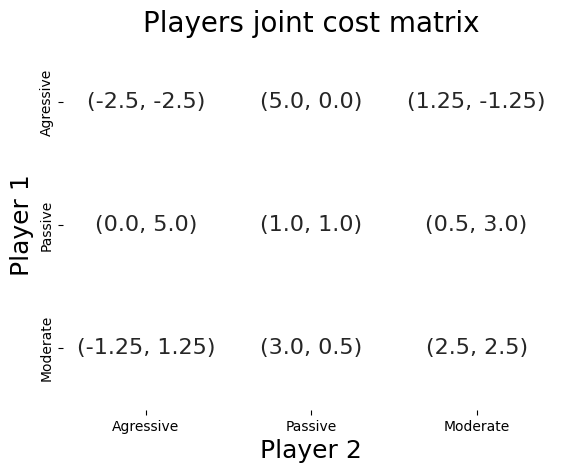

In [496]:
plot_joint_cost_matrix(costs_p1, costs_p2, label_actions_p1, label_actions_p2)

In [497]:
bqm = cost_matrices_to_bmq(costs_p1, costs_p2, label_actions_p1, label_actions_p2, lagrange_multiplier_scale=10)

{('P1_Agressive', 'P2_Agressive'): 5.0, ('P1_Agressive', 'P2_Passive'): -5.0, ('P1_Agressive', 'P2_Moderate'): -0.0, ('P1_Passive', 'P2_Agressive'): -5.0, ('P1_Passive', 'P2_Passive'): -2.0, ('P1_Passive', 'P2_Moderate'): -3.5, ('P1_Moderate', 'P2_Agressive'): -0.0, ('P1_Moderate', 'P2_Passive'): -3.5, ('P1_Moderate', 'P2_Moderate'): -5.0, ('alpha_0', 'alpha_0'): 1, ('alpha_1', 'alpha_1'): 2, ('alpha_2', 'alpha_2'): 4, ('alpha_3', 'alpha_3'): 8, ('beta_0', 'beta_0'): 1, ('beta_1', 'beta_1'): 2, ('beta_2', 'beta_2'): 4, ('beta_3', 'beta_3'): 8}


/Users/gcafferata/.pyenv/versions/3.9.8/envs/qhackathon/lib/python3.9/site-packages/dimod/binary/binary_quadratic_model.py:759: UserWarning: For constraints with fractional coefficients, multiply both sides of the inequality by an appropriate factor of ten to attain or approximate integer coefficients. 
  warnings.warn("For constraints with fractional coefficients, "


In [498]:
sampler = neal.SimulatedAnnealingSampler()
sampleset = sampler.sample(bqm, num_reads=5000)

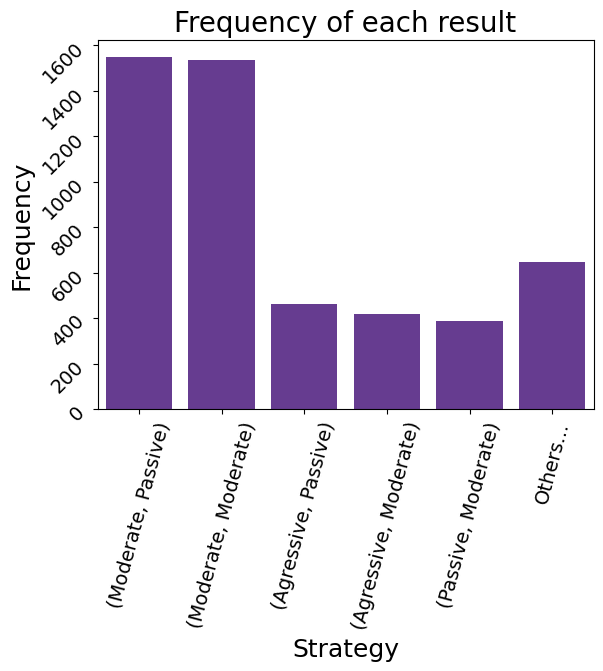

In [499]:
sampleset_result_plot(sampleset, label_actions_p1, label_actions_p2)